In [2]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.4 MB/s eta 0:00:00


In [3]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from sklearn import svm
from PIL import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score

**Mounted Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/faceRecognition/dataset/14_celeb.zip -d dataset

Archive:  /content/drive/MyDrive/faceRecognition/dataset/14_celeb.zip
  inflating: dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/316px-Anne_Hathaway_@_2018.09.15_Human_Rights_Campaign_National_Dinner,_Washington,_DC_USA_06194_(43805104245)_(cropped).jpg  
  inflating: dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/353px-Anne_Hathaway_2019_(cropped).jpg  
  inflating: dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/393px-Denzel_Washington_og_Anne_Hathaway_IMG_6550b_Harry_Wad.jpg  
  inflating: dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/398px-Anne_Hathaway_in_2017.png  
  inflating: dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/417px-Anne_Hathaway_in_2016.jpg  
  inflating: dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/428px-Anne_Hathaway_TIFF_2008.jpg  
  inflating: dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/443px-Anne_Hathaway_2013.jpg  
  inflating: dataset/14-celebrity-faces-dataset/d

**Util Function**

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

facenet = InceptionResnetV1(pretrained='vggface2').eval()
facenet = facenet.to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
device

device(type='cpu')

In [7]:
def whitens(img):
    mean = img.mean()
    std = img.std()
    std_adj = std.clamp(min=1.0 / (float(img.numel()) ** 0.5))
    y = (img - mean) / std_adj
    return y

def extract_features(mtcnn, facenet, img):
    img = img.to(device)
    img = transforms.ToPILImage()(img.squeeze_(0))
    bbs, _ = mtcnn.detect(img)
    if bbs is None:
        # if no face is detected
        return None, None

    faces = torch.stack([extract_face(img, bb) for bb in bbs])
    embeddings = facenet(whitens(faces)).detach().numpy()

    return bbs, embeddings

def dataset_to_embeddings(dataset, mtcnn, facenet):
    transform = transforms.Compose([
        transforms.Resize(160),
        transforms.ToTensor()
    ])

    embeddings = []
    labels = []
    for img_path, label in dataset.samples:
        print(img_path)

        _, embedding = extract_features(mtcnn, facenet, transform(Image.open(img_path).convert('RGB')).unsqueeze_(0))
        if embedding is None:
            print("Could not find face on {}".format(img_path))
            continue
        if embedding.shape[0] > 1:
            print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
            embedding = embedding[0, :]
        embeddings.append(embedding.flatten())
        labels.append(label)

    return np.stack(embeddings), labels

def train(embeddings, labels):
    clf = svm.SVC(probability=True)
    clf.fit(embeddings, labels)
    return clf

**Dataset**

In [ ]:
# Create the ImageFolder dataset
dataset_train = datasets.ImageFolder(root="/content/dataset/14-celebrity-faces-dataset/data/train")
dataset_val = datasets.ImageFolder(root="/content/dataset/14-celebrity-faces-dataset/data/val")

In [ ]:
transform = transforms.Compose([
    transforms.Resize(160),
    transforms.ToTensor()
])

test = extract_features(mtcnn, facenet, transform(dataset_train[30][0]))

In [ ]:
test[1].shape

(1, 512)

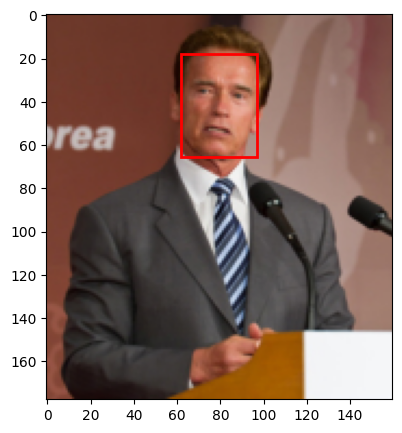

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

transform = transforms.Compose([
    transforms.Resize(160),
    # transforms.ToTensor()
])

def plot_img_bbox(img,target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target:
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# plotting the image with bboxes. Feel free to change the index
img = transform(dataset_train[30][0])
target = test[0]
plot_img_bbox(img,target)

**Facenet + SVM**

In [ ]:
X_train, y_train = dataset_to_embeddings(dataset_train, mtcnn, facenet)
X_test, y_test = dataset_to_embeddings(dataset_val, mtcnn, facenet)

X_train_class_idx = dataset_train.class_to_idx
X_test_class_idx = dataset_val.class_to_idx

embeddings, labels, class_to_idx = X_train, y_train, X_train_class_idx

/content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/316px-Anne_Hathaway_@_2018.09.15_Human_Rights_Campaign_National_Dinner,_Washington,_DC_USA_06194_(43805104245)_(cropped).jpg
/content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/353px-Anne_Hathaway_2019_(cropped).jpg
/content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/393px-Denzel_Washington_og_Anne_Hathaway_IMG_6550b_Harry_Wad.jpg
/content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/398px-Anne_Hathaway_in_2017.png
/content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/417px-Anne_Hathaway_in_2016.jpg
Multiple faces detected for /content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/417px-Anne_Hathaway_in_2016.jpg, taking one with highest probability
/content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/428px-Anne_Hathaway_TIFF_2008.jpg
/content/dataset/14-celebrity-faces-dataset/data/train/anne_hathaway/443px-Anne_Hathaway_2013

In [ ]:
clf = train(embeddings, labels)

In [ ]:
len(X_train)

220

In [ ]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(labels, clf.predict(embeddings), target_names=target_names))

# Predict labels for validation set and calculate accuracy
y_val_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_val_pred)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

{0: 'anne_hathaway', 1: 'arnold_schwarzenegger', 2: 'ben_afflek', 3: 'dwayne_johnson', 4: 'elton_john', 5: 'jerry_seinfeld', 6: 'kate_beckinsale', 7: 'keanu_reeves', 8: 'lauren_cohan', 9: 'madonna', 10: 'mindy_kaling', 11: 'simon_pegg', 12: 'sofia_vergara', 13: 'will_smith'}
                       precision    recall  f1-score   support

        anne_hathaway       1.00      0.93      0.97        15
arnold_schwarzenegger       1.00      1.00      1.00        18
           ben_afflek       1.00      1.00      1.00        14
       dwayne_johnson       1.00      1.00      1.00        15
           elton_john       1.00      1.00      1.00        17
       jerry_seinfeld       1.00      1.00      1.00        21
      kate_beckinsale       1.00      1.00      1.00        11
         keanu_reeves       1.00      1.00      1.00        11
         lauren_cohan       1.00      1.00      1.00        10
              madonna       1.00      1.00      1.00        19
         mindy_kaling       0.

#Facenet Only

In [ ]:
print(len(idx_to_class))

14


In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(idx_to_class)
).to(device)

**Train**

In [ ]:
data_dir = '/content/dataset/14-celebrity-faces-dataset/data/train'
dataset_train = datasets.ImageFolder(data_dir, transform=transforms.Resize((512,512)))
dataset_train.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset_train.samples
]

In [ ]:
batch_size = 32
epochs = 20
workers = 0 if os.name == 'nt' else 8

In [ ]:
train_loader = DataLoader(
    dataset_train,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(train_loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(train_loader)), end='')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch 1 of 7

/usr/local/lib/python3.10/dist-packages/facenet_pytorch/models/mtcnn.py:444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_boxes = np.array(selected_boxes)
/usr/local/lib/python3.10/dist-packages/facenet_pytorch/models/mtcnn.py:446: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_points = np.array(selected_points)


Batch 7 of 7

**Val**

In [ ]:
data_dir = '/content/dataset/14-celebrity-faces-dataset/data/val'
dataset_val = datasets.ImageFolder(data_dir, transform=transforms.Resize((512,512)))
dataset_val.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset_val.samples
]

In [ ]:
val_loader = DataLoader(
    dataset_val,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(val_loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(val_loader)), end='')

Batch 3 of 3

**Adapt dataset**

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

train_dataset = datasets.ImageFolder('/content/dataset/14-celebrity-faces-dataset/data/train_cropped', transform=trans)
img_inds_train = np.arange(len(train_dataset))
np.random.shuffle(img_inds_train)

val_dataset = datasets.ImageFolder('/content/dataset/14-celebrity-faces-dataset/data/val_cropped', transform=trans)
img_inds_val = np.arange(len(val_dataset))
np.random.shuffle(img_inds_val)

train_loader = DataLoader(
    train_dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(img_inds_train)
)
val_loader = DataLoader(
    val_dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(img_inds_val)
)

**Training**

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     3/3    | loss:    2.9185 | fps:   10.7326 | acc:    0.0868   

Epoch 1/20
----------
Train |     7/7    | loss:    1.5997 | fps:    4.3770 | acc:    0.5225   
Valid |     3/3    | loss:   41.6196 | fps:   12.0892 | acc:    0.1944   

Epoch 2/20
----------
Train |     7/7    | loss:    0.6901 | fps:    4.3875 | acc:    0.7936   
Valid |     3/3    | loss:    1.4225 | fps:   11.6816 | acc:    0.5764   

Epoch 3/20
----------
Train |     7/7    | loss:    0.3542 | fps:    4.4016 | acc:    0.8859   
Valid |     3/3    | loss:    1.4889 | fps:   11.2570 | acc:    0.5625   

Epoch 4/20
----------
Train |     7/7    | loss:    0.2075 | fps:    4.4209 | acc:    0.9350   
Valid |     3/3    | loss:    1.3540 | fps:   11.4276 | acc:    0.6042   

Epoch 5/20
----------
Train |     7/7    | loss:    0.2111 | fps:    4.4904 | acc:    0.9407   
Valid |     3/3    | loss:    1.1481 | fps:   11.2295 | acc:    0.6076   

Epoch 6/20
----------
Train |     7/7    | loss: 

In [ ]:
resnet.eval()
pred = []
label = []
for x,y in val_loader:
  pred += resnet(x).detach().cpu()
  label += y

In [ ]:
pred_test = [np.argmax(ele,axis = 0) for ele in pred]

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [ ]:
target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(label, pred_test, target_names=target_names))

                       precision    recall  f1-score   support

        anne_hathaway       1.00      0.67      0.80         6
arnold_schwarzenegger       1.00      0.80      0.89         5
           ben_afflek       0.67      0.80      0.73         5
       dwayne_johnson       1.00      0.80      0.89         5
           elton_john       0.56      1.00      0.71         5
       jerry_seinfeld       1.00      1.00      1.00         5
      kate_beckinsale       0.50      0.25      0.33         4
         keanu_reeves       1.00      0.80      0.89         5
         lauren_cohan       0.67      0.50      0.57         4
              madonna       1.00      0.80      0.89         5
         mindy_kaling       0.60      0.60      0.60         5
           simon_pegg       0.80      0.80      0.80         5
        sofia_vergara       0.50      0.83      0.62         6
           will_smith       0.80      0.80      0.80         5

             accuracy                           0.76 

#Faiss

**AutoFaiss - CLIP + FAISS**

In [ ]:
!pip install clip-retrieval autofaiss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.4/343.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 785.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 k

In [ ]:
!clip-retrieval inference --input_dataset /content/dataset/14-celebrity-faces-dataset/data/train_cropped --output_folder /content/dataset/train_embedding

The number of samples has been estimated to be 217
Starting the worker
dataset is 62
Starting work on task 0
100%|████████████████████████████████████████| 354M/354M [00:03<00:00, 101MiB/s]
warming up with batch size 256 on cpu
done warming up in 180.24375581741333s
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 sample_per_sec 4 ; sample_count 217 

In [ ]:
!autofaiss build_index --embeddings="/content/dataset/train_embedding/img_emb" \
                    --index_path="/content/knn.index" \
                    --index_infos_path="/content/infos.json" \
                    --metric_type="ip" \
                    --max_index_query_time_ms=10 \
                    --max_index_memory_usage="4GB"

2023-06-18 17:24:12,829 [INFO]: Using 2 omp threads (processes), consider increasing --nb_cores if you have more
2023-06-18 17:24:12,830 [INFO]: Launching the whole pipeline 06/18/2023, 17:24:12
2023-06-18 17:24:12,830 [INFO]: Reading total number of vectors and dimension 06/18/2023, 17:24:12
100% 1/1 [00:00<00:00, 17549.39it/s]
2023-06-18 17:24:12,860 [INFO]: There are 217 embeddings of dim 512
2023-06-18 17:24:12,861 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0309 secs
2023-06-18 17:24:12,861 [INFO]: 	Compute estimated construction time of the index 06/18/2023, 17:24:12
2023-06-18 17:24:12,861 [INFO]: 		-> Train: 16.7 minutes
2023-06-18 17:24:12,861 [INFO]: 		-> Add: 0.0 seconds
2023-06-18 17:24:12,861 [INFO]: 		Total: 16.7 minutes
2023-06-18 17:24:12,861 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0003 secs
2023-06-18 17:24:12,861 [INFO]: 	Checking that your have enough memory available to create the index 06/18/2023, 

**Search**

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.8 MB/s eta 0:00:00


In [ ]:
import faiss
import torch
import clip
import os
import pandas as pd
# import mtcnn

In [ ]:
df = pd.read_parquet("/content/dataset/train_embedding/metadata/metadata_0.parquet")
image_list = df["image_path"].tolist()
ind = faiss.read_index("/content/knn.index")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

**Set up val dataset**

In [ ]:
trans = transforms.Compose([
    np.float32,
    # transforms.ToTensor(),
    fixed_image_standardization
])

val_dataset = datasets.ImageFolder('/content/dataset/14-celebrity-faces-dataset/data/val_cropped')
test_class_idx = val_dataset.class_to_idx

In [ ]:
idx_to_class = {v: k for k, v in test_class_idx.items()}
print(idx_to_class)

target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(target_names)

{0: 'anne_hathaway', 1: 'arnold_schwarzenegger', 2: 'ben_afflek', 3: 'dwayne_johnson', 4: 'elton_john', 5: 'jerry_seinfeld', 6: 'kate_beckinsale', 7: 'keanu_reeves', 8: 'lauren_cohan', 9: 'madonna', 10: 'mindy_kaling', 11: 'simon_pegg', 12: 'sofia_vergara', 13: 'will_smith'}
['anne_hathaway', 'arnold_schwarzenegger', 'ben_afflek', 'dwayne_johnson', 'elton_john', 'jerry_seinfeld', 'kate_beckinsale', 'keanu_reeves', 'lauren_cohan', 'madonna', 'mindy_kaling', 'simon_pegg', 'sofia_vergara', 'will_smith']


In [ ]:
from PIL import Image
from collections import defaultdict

In [ ]:
labels = []
preds = []
k = 5
for x,y in val_dataset:
    image_tensor = preprocess(x)
    image_features = model.encode_image(torch.unsqueeze(image_tensor.to(device), dim=0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    image_embeddings = image_features.cpu().detach().numpy().astype('float32')
    D, I = ind.search(image_embeddings, k)
    # print(D,I)
    i_candidate = defaultdict(int)
    for D_ele,I_ele in zip(D[0],I[0]):
      if D_ele > 0.7:
        name = image_list[I_ele].split('/')[-2]
        i_candidate[test_class_idx[name]] += 1
    key_with_max_value = max(i_candidate, key=lambda k: i_candidate[k])

    preds.append(key_with_max_value)
    labels.append(y)

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [ ]:
target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(labels, preds, target_names=target_names))

                       precision    recall  f1-score   support

        anne_hathaway       1.00      0.67      0.80         6
arnold_schwarzenegger       0.83      1.00      0.91         5
           ben_afflek       0.67      0.80      0.73         5
       dwayne_johnson       1.00      0.80      0.89         5
           elton_john       1.00      1.00      1.00         5
       jerry_seinfeld       0.80      0.80      0.80         5
      kate_beckinsale       0.67      1.00      0.80         4
         keanu_reeves       1.00      0.80      0.89         5
         lauren_cohan       1.00      0.50      0.67         4
              madonna       1.00      1.00      1.00         5
         mindy_kaling       0.83      1.00      0.91         5
           simon_pegg       1.00      0.80      0.89         5
        sofia_vergara       0.86      1.00      0.92         6
           will_smith       0.83      1.00      0.91         5

             accuracy                           0.87 

**Facenet + Faiss**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

facenet = InceptionResnetV1(pretrained='vggface2').eval()
facenet = facenet.to(device)

In [ ]:
# import numpy as np
# data = np.load('/content/dataset/train_embedding/img_emb/img_emb_0.npy')
#data.shape

In [ ]:
embeddings, labels, class_to_idx = X_train, y_train, X_train_class_idx

In [ ]:
!rm -r facenet_emb
!mkdir facenet_emb

rm: cannot remove 'facenet_emb': No such file or directory


In [ ]:
np.save('/content/facenet_emb/facenet.npy', embeddings)

In [ ]:
!autofaiss build_index --embeddings="/content/facenet_emb" \
                    --index_path="/content/knn_facenet.index" \
                    --index_infos_path="/content/infos_facenet.json" \
                    --metric_type="ip" \
                    --max_index_query_time_ms=10 \
                    --max_index_memory_usage="4GB"

2023-06-18 17:31:42,214 [INFO]: Using 2 omp threads (processes), consider increasing --nb_cores if you have more
2023-06-18 17:31:42,214 [INFO]: Launching the whole pipeline 06/18/2023, 17:31:42
2023-06-18 17:31:42,214 [INFO]: Reading total number of vectors and dimension 06/18/2023, 17:31:42
100% 1/1 [00:00<00:00, 1347.35it/s]
2023-06-18 17:31:42,373 [INFO]: There are 220 embeddings of dim 512
2023-06-18 17:31:42,373 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.1589 secs
2023-06-18 17:31:42,373 [INFO]: 	Compute estimated construction time of the index 06/18/2023, 17:31:42
2023-06-18 17:31:42,374 [INFO]: 		-> Train: 16.7 minutes
2023-06-18 17:31:42,374 [INFO]: 		-> Add: 0.0 seconds
2023-06-18 17:31:42,374 [INFO]: 		Total: 16.7 minutes
2023-06-18 17:31:42,374 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0003 secs
2023-06-18 17:31:42,374 [INFO]: 	Checking that your have enough memory available to create the index 06/18/2023, 1

In [ ]:
ind = faiss.read_index("/content/knn_facenet.index")

In [ ]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [ ]:
preds = []
k = 1
for image_emb in X_test:
    D, I = ind.search(image_emb[np.newaxis, :], k)
    print(D,I)
    i_candidate = defaultdict(int)
    for D_ele,I_ele in zip(D[0],I[0]):
      # if D_ele > 0.7:
        cls = labels[I_ele]
        i_candidate[cls] += 1
    # try:
    key_with_max_value = max(i_candidate, key=lambda k: i_candidate[k])
    # except:
    #   print("error")
    #   key_with_max_value = 0

    preds.append(key_with_max_value)

[[0.5938838]] [[4]]
[[0.72991484]] [[12]]
[[0.7189412]] [[165]]
[[0.6188335]] [[12]]
[[0.813218]] [[12]]
[[0.7769711]] [[11]]
[[0.81208855]] [[22]]
[[0.8782115]] [[19]]
[[0.6629417]] [[25]]
[[0.8104662]] [[19]]
[[0.8269793]] [[30]]
[[0.741638]] [[42]]
[[0.7357062]] [[37]]
[[0.9597626]] [[38]]
[[0.4220538]] [[33]]
[[0.6477177]] [[43]]
[[0.6747613]] [[165]]
[[0.5302874]] [[57]]
[[0.7341124]] [[51]]
[[0.6875111]] [[53]]
[[0.8110631]] [[54]]
[[0.8913976]] [[69]]
[[0.54405385]] [[78]]
[[0.72608554]] [[67]]
[[0.80854964]] [[69]]
[[0.56915426]] [[76]]
[[0.77401054]] [[79]]
[[0.7221998]] [[85]]
[[0.7972399]] [[97]]
[[0.7731717]] [[79]]
[[0.8069067]] [[79]]
[[0.70185393]] [[100]]
[[0.6389573]] [[128]]
[[0.68013346]] [[101]]
[[0.6995804]] [[110]]
[[0.8878932]] [[114]]
[[0.6969079]] [[120]]
[[0.5649892]] [[119]]
[[0.8453629]] [[115]]
[[0.8609112]] [[111]]
[[0.6789805]] [[130]]
[[0.4405914]] [[80]]
[[0.4316514]] [[176]]
[[0.6332468]] [[127]]
[[0.7426251]] [[133]]
[[0.6865746]] [[141]]
[[0.78430593

In [ ]:
preds

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]

In [ ]:
target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(y_test, preds, target_names=target_names))

                       precision    recall  f1-score   support

        anne_hathaway       1.00      0.83      0.91         6
arnold_schwarzenegger       1.00      1.00      1.00         5
           ben_afflek       1.00      1.00      1.00         5
       dwayne_johnson       1.00      0.80      0.89         5
           elton_john       1.00      1.00      1.00         5
       jerry_seinfeld       0.83      1.00      0.91         5
      kate_beckinsale       1.00      0.75      0.86         4
         keanu_reeves       1.00      1.00      1.00         5
         lauren_cohan       0.67      0.50      0.57         4
              madonna       1.00      1.00      1.00         5
         mindy_kaling       0.71      1.00      0.83         5
           simon_pegg       0.83      1.00      0.91         5
        sofia_vergara       1.00      1.00      1.00         6
           will_smith       1.00      1.00      1.00         5

             accuracy                           0.93 

In [ ]:
preds

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]

**Alignment**

In [8]:
!pip install --upgrade imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
from google.colab.patches import cv2_imshow
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import math
import matplotlib.pyplot as plt

In [11]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/faceRecognition/dlib/shape_predictor_68_face_landmarks.dat')
predictor2 = dlib.shape_predictor('/content/drive/MyDrive/faceRecognition/dlib/shape_predictor_81_face_landmarks.dat')

In [12]:
def facial_landmarks(image):
    try:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = image

    # array of rectangles surrounding faces detected
    rectangles = detector(grayscale_image, 1)

    # If at least one face is detected, find its landmarks
    if len(rectangles) > 0:
        # Get 68 landmark points
        faceLandmarks = predictor(grayscale_image, rectangles[0])
        faceLandmarks = face_utils.shape_to_np(faceLandmarks)
        return faceLandmarks,rectangles
    else:
        return None

In [13]:
import cv2
import numpy as np
from skimage import transform as trans

__file__ = 'test'

# reference facial points, a list of coordinates (x,y)
REFERENCE_FACIAL_POINTS = [
    [30.29459953, 51.69630051],
    [65.53179932, 51.50139999],
    [48.02519989, 71.73660278],
    [33.54930115, 92.3655014],
    [62.72990036, 92.20410156]
]

DEFAULT_CROP_SIZE = (96, 112)


class FaceWarpException(Exception):
    def __str__(self):
        return 'In File {}:{}'.format(
            __file__, super.__str__(self))


def get_reference_facial_points(output_size=None,
                                inner_padding_factor=0.0,
                                outer_padding=(0, 0),
                                default_square=False):
    tmp_5pts = np.array(REFERENCE_FACIAL_POINTS)
    tmp_crop_size = np.array(DEFAULT_CROP_SIZE)

    # 0) make the inner region a square
    if default_square:
        size_diff = max(tmp_crop_size) - tmp_crop_size
        tmp_5pts += size_diff / 2
        tmp_crop_size += size_diff

    # print('---> default:')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    if (output_size and
            output_size[0] == tmp_crop_size[0] and
            output_size[1] == tmp_crop_size[1]):
        print('output_size == DEFAULT_CROP_SIZE {}: return default reference points'.format(tmp_crop_size))
        return tmp_5pts

    if (inner_padding_factor == 0 and
            outer_padding == (0, 0)):
        if output_size is None:
            print('No paddings to do: return default reference points')
            return tmp_5pts
        else:
            raise FaceWarpException(
                'No paddings to do, output_size must be None or {}'.format(tmp_crop_size))

    # check output size
    if not (0 <= inner_padding_factor <= 1.0):
        raise FaceWarpException('Not (0 <= inner_padding_factor <= 1.0)')

    if ((inner_padding_factor > 0 or outer_padding[0] > 0 or outer_padding[1] > 0)
            and output_size is None):
        output_size = tmp_crop_size * \
                      (1 + inner_padding_factor * 2).astype(np.int32)
        output_size += np.array(outer_padding)
        print('              deduced from paddings, output_size = ', output_size)

    if not (outer_padding[0] < output_size[0]
            and outer_padding[1] < output_size[1]):
        raise FaceWarpException('Not (outer_padding[0] < output_size[0]'
                                'and outer_padding[1] < output_size[1])')

    # 1) pad the inner region according inner_padding_factor
    # print('---> STEP1: pad the inner region according inner_padding_factor')
    if inner_padding_factor > 0:
        size_diff = tmp_crop_size * inner_padding_factor * 2
        tmp_5pts += size_diff / 2
        tmp_crop_size += np.round(size_diff).astype(np.int32)

    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 2) resize the padded inner region
    # print('---> STEP2: resize the padded inner region')
    size_bf_outer_pad = np.array(output_size) - np.array(outer_padding) * 2
    # print('              crop_size = ', tmp_crop_size)
    # print('              size_bf_outer_pad = ', size_bf_outer_pad)

    if size_bf_outer_pad[0] * tmp_crop_size[1] != size_bf_outer_pad[1] * tmp_crop_size[0]:
        raise FaceWarpException('Must have (output_size - outer_padding)'
                                '= some_scale * (crop_size * (1.0 + inner_padding_factor)')

    scale_factor = size_bf_outer_pad[0].astype(np.float32) / tmp_crop_size[0]
    # print('              resize scale_factor = ', scale_factor)
    tmp_5pts = tmp_5pts * scale_factor
    #    size_diff = tmp_crop_size * (scale_factor - min(scale_factor))
    #    tmp_5pts = tmp_5pts + size_diff / 2
    tmp_crop_size = size_bf_outer_pad
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 3) add outer_padding to make output_size
    reference_5point = tmp_5pts + np.array(outer_padding)
    tmp_crop_size = output_size
    # print('---> STEP3: add outer_padding to make output_size')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)
    #
    # print('===> end get_reference_facial_points\n')

    return reference_5point


def get_affine_transform_matrix(src_pts, dst_pts):
    tfm = np.float32([[1, 0, 0], [0, 1, 0]])
    n_pts = src_pts.shape[0]
    ones = np.ones((n_pts, 1), src_pts.dtype)
    src_pts_ = np.hstack([src_pts, ones])
    dst_pts_ = np.hstack([dst_pts, ones])

    A, res, rank, s = np.linalg.lstsq(src_pts_, dst_pts_)

    if rank == 3:
        tfm = np.float32([
            [A[0, 0], A[1, 0], A[2, 0]],
            [A[0, 1], A[1, 1], A[2, 1]]
        ])
    elif rank == 2:
        tfm = np.float32([
            [A[0, 0], A[1, 0], 0],
            [A[0, 1], A[1, 1], 0]
        ])

    return tfm


def warp_and_crop_face(src_img,
                       facial_pts,
                       reference_pts=None,
                       crop_size=(96, 112),
                       align_type='smilarity'):
    if reference_pts is None:
        if crop_size[0] == 96 and crop_size[1] == 112:
            reference_pts = REFERENCE_FACIAL_POINTS
        else:
            default_square = False
            inner_padding_factor = 0
            outer_padding = (0, 0)
            output_size = crop_size

            reference_pts = get_reference_facial_points(output_size,
                                                        inner_padding_factor,
                                                        outer_padding,
                                                        default_square)

    ref_pts = np.float32(reference_pts)
    ref_pts_shp = ref_pts.shape
    if max(ref_pts_shp) < 3 or min(ref_pts_shp) != 2:
        raise FaceWarpException(
            'reference_pts.shape must be (K,2) or (2,K) and K>2')

    if ref_pts_shp[0] == 2:
        ref_pts = ref_pts.T

    src_pts = np.float32(facial_pts)
    src_pts_shp = src_pts.shape
    if max(src_pts_shp) < 3 or min(src_pts_shp) != 2:
        raise FaceWarpException(
            'facial_pts.shape must be (K,2) or (2,K) and K>2')

    if src_pts_shp[0] == 2:
        src_pts = src_pts.T

    if src_pts.shape != ref_pts.shape:
        raise FaceWarpException(
            'facial_pts and reference_pts must have the same shape')

    if align_type == 'cv2_affine':
        tfm = cv2.getAffineTransform(src_pts[0:3], ref_pts[0:3])
    #        print('cv2.getAffineTransform() returns tfm=\n' + str(tfm))
    elif align_type == 'affine':
        tfm = get_affine_transform_matrix(src_pts, ref_pts)
    #        print('get_affine_transform_matrix() returns tfm=\n' + str(tfm))
    else:
        # tfm = get_similarity_transform_for_cv2(src_pts, ref_pts)
        tform = trans.SimilarityTransform()
        tform.estimate(src_pts, ref_pts)
        tfm = tform.params[0:2, :]

    face_img = cv2.warpAffine(src_img, tfm, (crop_size[0], crop_size[1]))

    return face_img

In [14]:
!mkdir dataset/train_crop
!mkdir dataset/val_crop

In [17]:
for path in os.listdir('/content/dataset/14-celebrity-faces-dataset/data/train'):
  try:
    os.mkdir(f'/content/dataset/train_crop/{path}')
    os.chdir(f'/content/dataset/train_crop/{path}')
  except:
    os.chdir(f'/content/dataset/train_crop/{path}')
  for link in os.listdir('/content/dataset/14-celebrity-faces-dataset/data/train/' + path):
    try:
      originalImage = cv2.imread(f'/content/dataset/14-celebrity-faces-dataset/data/train/{path}/{link}')
      landmarks,rec = facial_landmarks(originalImage)
      (x, y, w, h) = face_utils.rect_to_bb(rec[0])
      a = [landmarks[17],landmarks[26],landmarks[33],landmarks[4],landmarks[12]]
      img = warp_and_crop_face(originalImage,a,reference_pts=None,crop_size=(96,112),align_type='')
      cv2.imwrite(f'{link}', img)
    except:
      continue

In [18]:
for path in os.listdir('/content/dataset/14-celebrity-faces-dataset/data/val'):
  # try:
  #   os.chdir(f'/content/dataset/train_crop/{path}')
  # except:
  os.mkdir(f'/content/dataset/val_crop/{path}')
  os.chdir(f'/content/dataset/val_crop/{path}')
  for link in os.listdir('/content/dataset/14-celebrity-faces-dataset/data/val/' + path):
    try:
      originalImage = cv2.imread(f'/content/dataset/14-celebrity-faces-dataset/data/val/{path}/{link}')
      landmarks,rec = facial_landmarks(originalImage)
      (x, y, w, h) = face_utils.rect_to_bb(rec[0])
      a = [landmarks[17],landmarks[26],landmarks[33],landmarks[4],landmarks[12]]
      img = warp_and_crop_face(originalImage,a,reference_pts=None,crop_size=(96,112),align_type='')
      cv2.imwrite(f'{link}', img)
    except:
      continue

In [19]:
dataset_train = datasets.ImageFolder(root="/content/dataset/train_crop")
dataset_val = datasets.ImageFolder(root="/content/dataset/val_crop")

X_train, y_train = dataset_to_embeddings(dataset_train, mtcnn, facenet)
X_test, y_test = dataset_to_embeddings(dataset_val, mtcnn, facenet)

X_train_class_idx = dataset_train.class_to_idx
X_test_class_idx = dataset_val.class_to_idx

embeddings, labels, class_to_idx = X_train, y_train, X_train_class_idx

/content/dataset/train_crop/anne_hathaway/316px-Anne_Hathaway_@_2018.09.15_Human_Rights_Campaign_National_Dinner,_Washington,_DC_USA_06194_(43805104245)_(cropped).jpg
/content/dataset/train_crop/anne_hathaway/353px-Anne_Hathaway_2019_(cropped).jpg
/content/dataset/train_crop/anne_hathaway/393px-Denzel_Washington_og_Anne_Hathaway_IMG_6550b_Harry_Wad.jpg
/content/dataset/train_crop/anne_hathaway/398px-Anne_Hathaway_in_2017.png
/content/dataset/train_crop/anne_hathaway/417px-Anne_Hathaway_in_2016.jpg
/content/dataset/train_crop/anne_hathaway/428px-Anne_Hathaway_TIFF_2008.jpg
/content/dataset/train_crop/anne_hathaway/443px-Anne_Hathaway_2013.jpg
Multiple faces detected for /content/dataset/train_crop/anne_hathaway/443px-Anne_Hathaway_2013.jpg, taking one with highest probability
/content/dataset/train_crop/anne_hathaway/476px-Anne_Hathaway_(cropped)_(cropped).png
/content/dataset/train_crop/anne_hathaway/498px-Anne_Hathaway_for_AHC.png
/content/dataset/train_crop/anne_hathaway/505px-Anne_H

In [20]:
!rm -r /content/facenet_emb
!mkdir /content/facenet_emb

rm: cannot remove '/content/facenet_emb': No such file or directory


In [21]:
np.save('/content/facenet_emb/facenet.npy', embeddings)

In [22]:
!pip install autofaiss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 96.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115927 sha256=52dd512f3ad343eb6edd96c892d9f0840f0184b868bb900f88f161c1808f738c
  Stored in directory: /root/.cache/pip/wheels/26/9a/dd/2818b1b023daf077ec3e625c47ae446aca587a5abe48e05212
Successfully built fire


In [23]:
!autofaiss build_index --embeddings="/content/facenet_emb" \
                    --index_path="/content/knn_facenet.index" \
                    --index_infos_path="/content/infos_facenet.json" \
                    --metric_type="ip" \
                    --max_index_query_time_ms=10 \
                    --max_index_memory_usage="4GB"

2023-06-19 09:13:55,085 [INFO]: Using 2 omp threads (processes), consider increasing --nb_cores if you have more
2023-06-19 09:13:55,086 [INFO]: Launching the whole pipeline 06/19/2023, 09:13:55
2023-06-19 09:13:55,086 [INFO]: Reading total number of vectors and dimension 06/19/2023, 09:13:55
100% 1/1 [00:00<00:00, 19418.07it/s]
2023-06-19 09:13:55,116 [INFO]: There are 212 embeddings of dim 512
2023-06-19 09:13:55,117 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0313 secs
2023-06-19 09:13:55,117 [INFO]: 	Compute estimated construction time of the index 06/19/2023, 09:13:55
2023-06-19 09:13:55,118 [INFO]: 		-> Train: 16.7 minutes
2023-06-19 09:13:55,118 [INFO]: 		-> Add: 0.0 seconds
2023-06-19 09:13:55,118 [INFO]: 		Total: 16.7 minutes
2023-06-19 09:13:55,118 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0005 secs
2023-06-19 09:13:55,118 [INFO]: 	Checking that your have enough memory available to create the index 06/19/2023, 

In [24]:
import faiss
import torch
import os
import pandas as pd
from collections import defaultdict

In [25]:
ind = faiss.read_index("/content/knn_facenet.index")

In [32]:
preds = []
k = 5
for image_emb in X_test:
    D, I = ind.search(image_emb[np.newaxis, :], k)
    print(D,I)
    i_candidate = defaultdict(int)
    for D_ele,I_ele in zip(D[0],I[0]):
      # if D_ele > 0.7:
        cls = labels[I_ele]
        i_candidate[cls] += 1
    # try:
    key_with_max_value = max(i_candidate, key=lambda k: i_candidate[k])
    # except:
    #   print("error")
    #   key_with_max_value = 0

    preds.append(key_with_max_value)

[[0.6899878  0.6724212  0.6262628  0.6081525  0.60472775]] [[ 9 12 11 10  8]]
[[0.7285872  0.716966   0.70215154 0.69975615 0.69495666]] [[12  9 14  1  2]]
[[0.35817882 0.31920582 0.3185969  0.30792633 0.28417438]] [[208  55  71  68  57]]
[[0.6290043  0.6275903  0.6202243  0.61533326 0.5817783 ]] [[ 0 12  8  9 11]]
[[0.7810314  0.771695   0.7348503  0.70855355 0.6952033 ]] [[ 9 12  2  0  4]]
[[0.7701489  0.7293953  0.7151933  0.711872   0.70969987]] [[11  9 12 10  0]]
[[0.7660855 0.762286  0.7306418 0.7135272 0.7056538]] [[22 26 30 28 20]]
[[0.86156046 0.66745764 0.63020647 0.62061465 0.5919219 ]] [[19 25 23 18 26]]
[[0.6429915  0.6386284  0.62011385 0.6145257  0.6015434 ]] [[17 25 23 18 20]]
[[0.7629591 0.6328909 0.6184752 0.6015593 0.6001377]] [[19 23 17 22 25]]
[[0.8041169 0.7991461 0.784416  0.7837486 0.738341 ]] [[30 26 20 28 27]]
[[0.63068545 0.6127332  0.5875063  0.57932496 0.51305753]] [[41 42 33 38 34]]
[[0.73820114 0.69468373 0.6858582  0.6767702  0.65058136]] [[39 34 42 45 3

In [27]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [28]:
test_class_idx = dataset_val.class_to_idx

idx_to_class = {v: k for k, v in test_class_idx.items()}
print(idx_to_class)

target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(target_names)

{0: 'anne_hathaway', 1: 'arnold_schwarzenegger', 2: 'ben_afflek', 3: 'dwayne_johnson', 4: 'elton_john', 5: 'jerry_seinfeld', 6: 'kate_beckinsale', 7: 'keanu_reeves', 8: 'lauren_cohan', 9: 'madonna', 10: 'mindy_kaling', 11: 'simon_pegg', 12: 'sofia_vergara', 13: 'will_smith'}
['anne_hathaway', 'arnold_schwarzenegger', 'ben_afflek', 'dwayne_johnson', 'elton_john', 'jerry_seinfeld', 'kate_beckinsale', 'keanu_reeves', 'lauren_cohan', 'madonna', 'mindy_kaling', 'simon_pegg', 'sofia_vergara', 'will_smith']


In [33]:
target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(y_test, preds, target_names=target_names))

                       precision    recall  f1-score   support

        anne_hathaway       1.00      0.83      0.91         6
arnold_schwarzenegger       1.00      1.00      1.00         5
           ben_afflek       1.00      1.00      1.00         4
       dwayne_johnson       0.83      1.00      0.91         5
           elton_john       0.83      1.00      0.91         5
       jerry_seinfeld       1.00      1.00      1.00         5
      kate_beckinsale       1.00      1.00      1.00         4
         keanu_reeves       1.00      1.00      1.00         5
         lauren_cohan       1.00      1.00      1.00         4
              madonna       1.00      0.80      0.89         5
         mindy_kaling       1.00      1.00      1.00         5
           simon_pegg       1.00      1.00      1.00         4
        sofia_vergara       1.00      1.00      1.00         6
           will_smith       1.00      1.00      1.00         5

             accuracy                           0.97 